In [1]:
# Import necessary libraries
import sys
import pandas as pd          
import numpy as np           
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
from PIL import Image
import seaborn as sns       
import tensorflow as tf     
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, GlobalAveragePooling2D,Dropout, Flatten, Dense
from tensorflow.keras.applications import VGG16, ResNet50
from tensorflow.keras.optimizers import Adam

In [2]:
# Importing the drive module from the google.colab library
from google.colab import drive

# Mounting Google Drive to the '/content/drive' directory
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# Unzipping the 'images.zip' file located in 'drive/My Drive' directory
!unzip drive/My\ Drive/images.zip

In [4]:
# Specify the base path where your image data is stored
base_path = '/content/real_vs_fake/real-vs-fake/'


# Create an ImageDataGenerator for image preprocessing and augmentation
image_gen = ImageDataGenerator(rescale=1./255.,
                               horizontal_flip=True)
# The 'rescale' parameter normalizes pixel values to the range [0, 1] by dividing each pixel value by 255

In [5]:
# Configuring image data generators for the ResNet50 model on the training, validation, and test sets
# Training set data generator
ResNet50_train=image_gen.flow_from_directory(
    base_path + 'train/',
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary'
)
# Validation set data generator
ResNet50_valid=image_gen.flow_from_directory(
    base_path + 'valid/',
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary'
)
# Test set data generator
ResNet50_test=image_gen.flow_from_directory(
    base_path + 'test/',
    target_size=(224, 224),
    batch_size=128,
    class_mode='binary',
    shuffle=False
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [6]:
# Setting the learning rate for the optimizer
learning_rate = 0.0001

In [7]:
# Setting up early stopping based on validation loss monitoring
early_stopping=EarlyStopping(
    monitor='val_loss',         # Monitoring validation loss for early stopping
    patience=5,                  # Waiting for 5 epochs before considering early stopping
    restore_best_weights=True    # Restoring the model to its best weights when early stopping is triggered
)

In [8]:
# Using the ResNet50 model architecture with pre-trained weights from ImageNet
base_model = ResNet50(
    weights='imagenet',         # Load pre-trained weights from ImageNet
    include_top=False,          # Exclude the fully-connected layers at the top
    input_shape=(224, 224, 3)   # Setting the input shape for the model's expected image size
)

94765736/94765736 [==============================] - 4s 0us/step


In [9]:
# Iterating through each layer in the base model
for layer in base_model.layers:
    # Setting each layer to be non-trainable to retain pre-trained weights
    layer.trainable = False

In [12]:
# Building a custom model on top of the pre-trained ResNet50 base model
# Creating a Sequential model
model = Sequential()

# Adding the pre-trained Xception base model to the custom model
model.add(base_model)

# Adding a Global Average Pooling layer to reduce spatial dimensions
model.add(GlobalAveragePooling2D())

# Adding a fully connected layer with 256 units and ReLU activation
model.add(Dense(256, activation='relu'))

# Adding a Dropout layer with 50% dropout rate for regularization
model.add(Dropout(0.5))

# Adding the final output layer with a single unit and sigmoid activation for binary classification
model.add(Dense(1, activation='sigmoid'))

# Displaying the summary of the custom model architecture
model.summary()

# Configuring the model for training using the Adam optimizer
model.compile(
    optimizer=Adam(learning_rate=learning_rate),   # Using Adam optimizer with the defined learning rate
    loss='binary_crossentropy',                   # Binary crossentropy loss for binary classification
    metrics=['accuracy']                          # Evaluating model performance using accuracy metric
)

In [13]:
# Fitting the model to the training data for 100 epochs
history=model.fit(
    ResNet50_train,              # Training data
    epochs=100,                  # Number of training epochs
    validation_data=VGG16_valid,  # Validation data for monitoring
    callbacks=[early_stopping]   # EarlyStopping callback for stopping training based on validation loss
)

Epoch 1/100
782/782 [==============================] - 382s 471ms/step - loss: 0.7050 - accuracy: 0.5715 - val_loss: 0.6372 - val_accuracy: 0.6464
Epoch 2/100
782/782 [==============================] - 366s 467ms/step - loss: 0.6768 - accuracy: 0.5578 - val_loss: 0.6930 - val_accuracy: 0.5052
Epoch 3/100
782/782 [==============================] - 365s 467ms/step - loss: 0.6540 - accuracy: 0.6183 - val_loss: 0.6915 - val_accuracy: 0.5404
Epoch 4/100
782/782 [==============================] - 366s 468ms/step - loss: 0.6402 - accuracy: 0.6345 - val_loss: 0.6129 - val_accuracy: 0.6816
Epoch 5/100
782/782 [==============================] - 366s 467ms/step - loss: 0.6344 - accuracy: 0.6423 - val_loss: 0.6059 - val_accuracy: 0.6914
Epoch 6/100
782/782 [==============================] - 365s 467ms/step - loss: 0.6293 - accuracy: 0.6496 - val_loss: 0.6073 - val_accuracy: 0.6900
Epoch 7/100
782/782 [==============================] - 365s 467ms/step - loss: 0.6269 - accuracy: 0.6507 - val_loss: 0

In [14]:
# Saving the training history to a pickle file
with open('/content/drive/MyDrive/face2face/models/ResNet_history.pkl', 'wb') as f:
    pickle.dump(ResNet_history, f)

# Saving the trained ResNet model to a pickle file
with open('/content/drive/MyDrive/face2face/models/ResNet.pkl', 'wb') as f:
    pickle.dump(model, f)

In [15]:
# Using the evaluate method to assess model performance on the ResNet50 test set
evaluation_results = model.evaluate(ResNet50_test)

157/157 [==============================] - 61s 388ms/step - loss: 0.5532 - accuracy: 0.7274


[0.5531788468360901, 0.727400004863739]

In [16]:
# Obtaining true class labels from the test set
y_true = ResNet50_test.classes

# Obtaining predicted probabilities for each class from the trained model
y_pred = model.predict(ResNet50_test)

157/157 [==============================] - 62s 385ms/step


In [17]:
# Applying a threshold of 0.5 to the predicted probabilities
# If the probability is greater than 0.5, set the label to 1 (positive), else 0 (negative)
y_pred_labels = (y_pred > 0.5).astype(int)

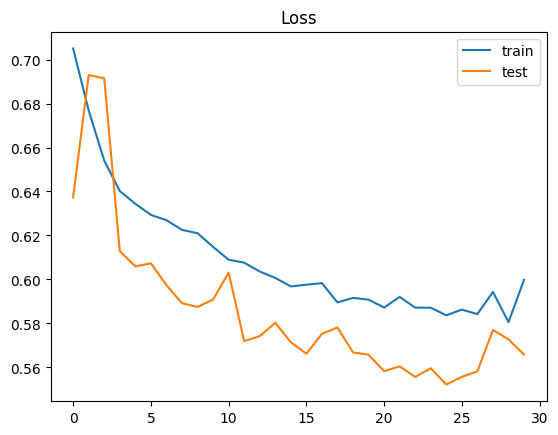

In [19]:
# Plotting the training loss curve with a label 'train'
plt.plot(ResNet_history.history['loss'], label='train')

# Plotting the validation loss curve with a label 'test'
plt.plot(ResNet_history.history['val_loss'], label='test')

# Adding a legend to the plot
plt.legend()

# Setting the title of the plot to 'Loss'
plt.title('Loss')

# Displaying the plot
plt.show()

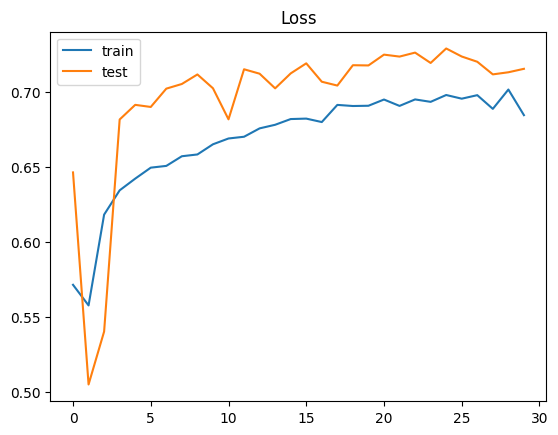

In [20]:
# Plotting the training accuracy curve with a label 'train'
plt.plot(ResNet_history.history['accuracy'], label='train')

# Plotting the validation accuracy curve with a label 'test'
plt.plot(ResNet_history.history['val_accuracy'], label='test')

# Adding a legend to the plot
plt.legend()

# Setting the title of the plot to 'Accuracy'
plt.title('Accuracy')

# Displaying the plot
plt.show()

In [21]:
# Import necessary libraries
from sklearn.metrics import confusion_matrix, classification_report

In [22]:
# Creating a confusion matrix to analyze model performance
confusion_matrix(y_true, y_pred_labels)

array([[6991, 3009],
       [2431, 7569]])

In [23]:
# Creating a classification report to assess model performance
ResNet_metrics = classification_report(y_true, y_pred_labels)

In [24]:
# Displaying classification report
print(ResNet_metrics)

              precision    recall  f1-score   support

           0       0.74      0.70      0.72     10000
           1       0.72      0.76      0.74     10000

    accuracy                           0.73     20000
   macro avg       0.73      0.73      0.73     20000
weighted avg       0.73      0.73      0.73     20000

